In [1]:
import os
import random
import zipfile
import urllib.request
import itertools
import numpy as np
from keras.preprocessing import image
import seaborn as sns
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_file_name = '/content/drive/Othercomputers/My Computer/Computer vision/projects/dl and cnns/adidas/archive.zip'
dir = './images'
zip_ref = zipfile.ZipFile(data_file_name, 'r')
zip_ref.extractall(dir)
zip_ref.close()

In [4]:
print('number of training adidas images: ', len(os.listdir('./images/train/adidas/')))
print('number of training converse images: ', len(os.listdir('./images/train/converse/')))
print('number of training nike images: ', len(os.listdir('./images/train/nike/')))
print('number of testing adidas images: ', len(os.listdir('./images/test/adidas/')))
print('number of testing converse images: ', len(os.listdir('./images/test/converse/')))
print('number of testing nike images: ', len(os.listdir('./images/test/nike/')))

number of training adidas images:  237
number of training converse images:  237
number of training nike images:  237
number of testing adidas images:  38
number of testing converse images:  38
number of testing nike images:  38


In [5]:
TRAINING_DIR = './images/train/'
train_generator = ImageDataGenerator( 
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest').flow_from_directory(TRAINING_DIR,
                                             batch_size=32,
                                             class_mode='categorical',
                                             target_size=(240, 240))

VALIDATION_DIR = './images/test/'
validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(VALIDATION_DIR,
                                        batch_size=32,
                                        class_mode='categorical',
                                        target_size=(240, 240))

Found 711 images belonging to 3 classes.
Found 114 images belonging to 3 classes.


In [6]:
weights_url = 'https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
weights_file = 'inception_v3.h5'
urllib.request.urlretrieve(weights_url, weights_file)

inception_v3 = InceptionV3(input_shape=(240, 240, 3), include_top=False, weights=None)
inception_v3.load_weights(weights_file)
for layer in inception_v3.layers:
    layer.trainable = False

last_layer = inception_v3.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 13, 13, 768)


In [ ]:
#### Top k categorical classification
# from keras.metrics import top_k_categorical_accuracy
# def top_5_categorical_accuracy(y_true, y_pred):
#     return top_k_categorical_accuracy(y_true, y_pred, k=1) 

In [7]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu', kernel_initializer='he_uniform')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation='relu', kernel_initializer='he_uniform')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(3, activation='softmax')(x)

model = Model(inception_v3.input, x)

In [8]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, TensorBoard
#Overwrite the model each time accuracy improves. Saves a lot of space. 
filepath="./best_model.hdf5" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss. 
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
#This callback will stop the training when there is no improvement in
# the validation loss for three consecutive epochs.

#CSVLogger logs epoch, accuracy, loss, val_accuracy, val_loss. So we can plot later.
log_csv = CSVLogger('/content/drive/MyDrive/Colab Notebooks/saved_logs/my_logs.csv', separator=',', append=False)

callbacks_list = [checkpoint]
tb = TensorBoard(log_dir='.')

In [10]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/10
23/23 [==============================] - ETA: 0s - loss: 1.8271 - accuracy: 0.4219
Epoch 1: val_accuracy improved from -inf to 0.51754, saving model to ./best_model.hdf5
23/23 [==============================] - 34s 861ms/step - loss: 1.8271 - accuracy: 0.4219 - val_loss: 3.9629 - val_accuracy: 0.5175
Epoch 2/10
23/23 [==============================] - ETA: 0s - loss: 1.0863 - accuracy: 0.5626
Epoch 2: val_accuracy did not improve from 0.51754
23/23 [==============================] - 10s 439ms/step - loss: 1.0863 - accuracy: 0.5626 - val_loss: 1.8618 - val_accuracy: 0.5000
Epoch 3/10
23/23 [==============================] - ETA: 0s - loss: 0.8801 - accuracy: 0.6357
Epoch 3: val_accuracy improved from 0.51754 to 0.62281, saving model to ./best_model.hdf5
23/23 [==============================] - 17s 738ms/step - loss: 0.8801 - accuracy: 0.6357 - val_loss: 1.1865 - val_accuracy: 0.6228
Epoch 4/10
23/23 [==============================] - ETA: 0s - loss: 0.7537 - accuracy: 0.6948


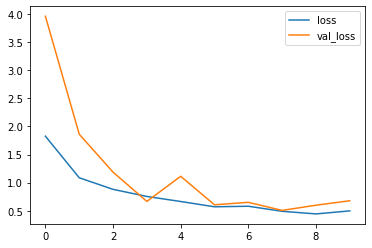

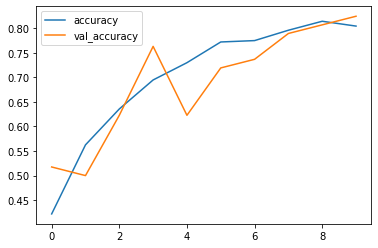

In [11]:
### with matplotlib
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(len(acc))
# plt.plot(epochs, acc, 'r', 'Training accuracy')
# plt.plot(epochs, val_acc, 'b', 'Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.figure()

### with pandas
import pandas as pd
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [12]:
loss, accuracy = model.evaluate(validation_generator, batch_size=32)
print(loss, accuracy)

4/4 [==============================] - 0s 78ms/step - loss: 0.6771 - accuracy: 0.8246
0.6770824193954468 0.8245614171028137


In [13]:
from sklearn.metrics import confusion_matrix

test_labels = validation_generator.classes
predictions = model.predict(x=validation_generator, steps=len(validation_generator), verbose=0)
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

Confusion matrix unnormalized
[[11 14 13]
 [ 6 16 16]
 [ 6 13 19]]


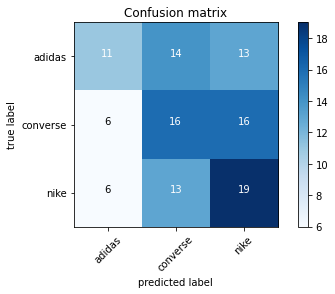

In [14]:
def plot_confusion_matrix(cm, 
                          classes, 
                          normalize=False, 
                          title='Confusion matrix', 
                          cmap=plt.cm.Blues):
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
  else:
    print('Confusion matrix unnormalized')

  print(cm)
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0],), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment='center',
             color='white' if cm[i, j] > thresh else 'black')
    
  plt.tight_layout()
  plt.ylabel('true label')
  plt.xlabel('predicted label')


cm_plot_labels = ['adidas', 'converse', 'nike']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion matrix')

In [15]:
img = image.load_img('./images/test/adidas/30.jpg', target_size=(240, 240))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

image_tensor = np.vstack([x])
classes = model.predict(image_tensor)
print(classes)

[[1. 0. 0.]]


expected output  tf.Tensor([[0. 1. 0.]], shape=(1, 3), dtype=float32)
predictions tf.Tensor([[1.8943906e-07 8.5258782e-01 1.4741197e-01]], shape=(1, 3), dtype=float32)


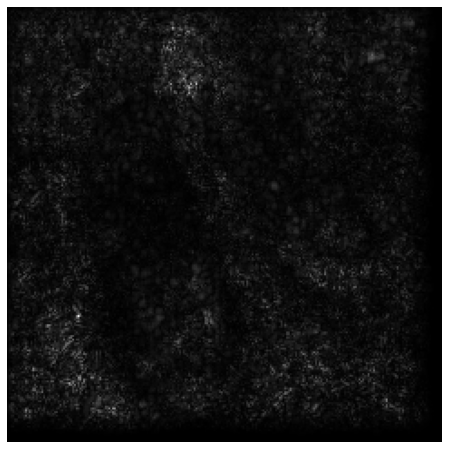

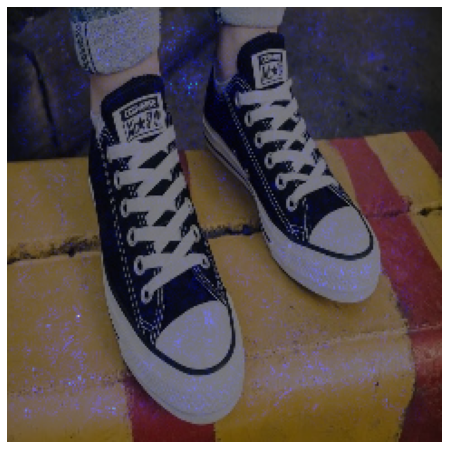

In [25]:
def do_salience(image, model, label, prefix):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (240, 240))
    img = img/255.0
    img = np.expand_dims(img, axis=0)
    num_classes = 3
    expected_output = tf.one_hot([label] * img.shape[0], num_classes)
    print('expected output ', expected_output)
    with tf.GradientTape() as tape:
        inputs = tf.cast(img, tf.float32)
        tape.watch(inputs)
        predictions = model(inputs)
        print('predictions', predictions)
        loss = tf.keras.losses.categorical_crossentropy(
            expected_output, predictions
        )
    gradients = tape.gradient(loss, inputs)
    grayscale_tensor = tf.reduce_sum(tf.abs(gradients), axis=-1)
    normalized_tensor = tf.cast(
        255
        * (grayscale_tensor-tf.reduce_min(grayscale_tensor))
        / (tf.reduce_max(grayscale_tensor)-tf.reduce_min(grayscale_tensor)),
        tf.uint8
    )
    normalized_tensor = tf.squeeze(normalized_tensor)
    img = tf.squeeze(img).numpy()

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.imshow(normalized_tensor, cmap='gray')
    plt.show()

    gradient_color = cv2.applyColorMap(normalized_tensor.numpy(), cv2.COLORMAP_HOT)
    gradient_color = gradient_color / 255.
    super_imposed = cv2.addWeighted(img, 0.5, gradient_color, 0.5, 0.0)
    plt.figure(figsize=(8, 8))
    plt.imshow(super_imposed)
    plt.axis('off')
    plt.show()

    salient_image_name = prefix + image
    normalized_tensor = tf.expand_dims(normalized_tensor, -1)
    normalized_tensor = tf.io.encode_jpeg(normalized_tensor, quality=100, format='grayscale')
    writer = tf.io.write_file(salient_image_name, normalized_tensor)

do_salience('./images/test/converse/25.jpg', model, 1, 'salient')